In [1]:
current_month = "202207"
valuation_method = 'historic' ## For now, because of data availability, we'll use current valuations.
ERP_method = "Country of Incorporation" ## For now, because of data availability, we'll use Country of company.
global_ind = False ## For now, because of only focused on US.
single_ind = True ## For now, because of data availability, we'll use single industry data.

import pandas as pd
import numpy as np
from utils import mergeFuzzyDate


Cost of Equity = Riskfree Rate + Levered Beta * (Equity Risk Premium)

1. Rf
2. Levered beta
3. ERP 

Or
CoE = Rf  + lambda * CRP  + levered_beta*ERP (if lambda available)

# 1. Risk free Rate (session 4)

## 1.1 US
__Option1 (easy): Risk free rate = US treasury 10-y bond rate__

Option2 (if dont trust gov.): Intrinsic Risk free rate = Inflation in currency + Real growth (GDP)

## 1.2 EUR - Out of Scope for now
## 1.3 Rest - Out of Scope for now

In [2]:
def getlastUSBondRate():
    """ Get most recent 10-y US Treasury Bond rate, to be used as the Risk free rate. """
    df = pd.read_csv(f"https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/all/202207?type=daily_treasury_yield_curve&field_tdr_date_value_month={current_month}&page&_format=csv")
    df = df[['Date', '10 Yr']]
    df.columns = ['Date', 'RiskFree_Rate']

    Riskfree_Rate = df[df.Date == df.Date.max()].iloc[0]['RiskFree_Rate']    
    Riskfree_Rate = Riskfree_Rate / 100

    return Riskfree_Rate
# getlastUSBondRate()

# 2. Country Risk Premium (session 5)

Premium that stocks have historically earned over riskless securities.
Normally is the country where a company gets the revenue. In some cases could be where the company sits (eg petro company in Middle east)
For now, we'll asume it's always the first case, as only US companies for now.

## 2.1 US (Mature Market)
__CRP = Implied Equity Risk Premium S&P500__
Inputs needed:
- MV: Market Value (current price)
- ED: Adjusted Dividends paid (TTM last 12 months)
- EB: Adjustd Buybacks (TTM last 12 months)
- eg: 5 years expected earnings growth (overall)
- Rf: Riskfree rate

Solve the equation for r:
MV = (ED+EB)*(1+eg)/(1+r) + (ED+EB)*(1+eg)^2/(1+r)^2 + (ED+EB)*(1+eg)^3/(1+r)^3 + (ED+EB)*(1+eg)^4/(1+r)^4 + (ED+EB)*(1+eg)^5/(1+r)^5 + (ED+EB)*(1+eg)^5/(1+r)^5*Rf/(r-Rf)

And CRP = r - Rf

Or get it from the God Aswath Damodaran:
- By month (2008+): https://pages.stern.nyu.edu/~adamodar/pc/implprem/ERPbymonth.xlsx
- Yearly (1960+): https://pages.stern.nyu.edu/~adamodar/pc/datasets/histimpl.xls

## 2.2 Rest

### 2.2.1 Default Spread
CRP = CRP_US + Default Spread of country. 

3 options to calculate:
- The default spread on a dollar denominated bond issued by the country (country bond USD - US bond USD)

- The sovereign CDS spread for the country. (10-y CDS spread) 

__- Country's sovereign local currency rating (Aaa, Ba2,...) and the default spread for the given rating (Moody's)__

### 2.2.2 Equity volatility
- Total equity risk premium = CRP_US* std(Country Equity) / std(US Equity)
- CRP = Total equity risk premium - CRP_US

### 2.2.3 Equity volatility
- CRP = CRP_US + Default spread on country bond* std(Country Equity) / std(Country Bond)

## 2.3. Calculate CRP Framework

Monthly:
1. Calculate CRP = Implied Equity Risk Premium S&P500
2. Check Moody's rating for each country (on sovereign currency)
3. If not available -> Check S&P & convert to Moody's
Semi Annualy:
- Ratings = AAA -> ERP = ERP_US
- Rating < AAA -> ERP = ERP_US + Default Spread *Relative Equity Market Volatility
    - Default Spread = Rating score
    - Relative Equity Market Volatility = std(Country Equity idx) / std(Country Bond idx)
- If Ratings = NA -> Score from PRS. ERP = PRS - Based ERP

## 2.4. Lazy approach 
Also possible to get this data from God Aswath Damodaran (updated Jan of year):
https://pages.stern.nyu.edu/~adamodar/pc/datasets/ctryprem.xlsx

In [76]:
## Create function to compute ERP for US
def get_US_Rf_MRP_month():
    """ Get US ERP from our God Aswath Damodaran's website. Monthly since 2018. """
    MRP_US = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/implprem/ERPbymonth.xlsx", sheet_name="Historical ERP")
    MRP_US = MRP_US[['Start of month', 'T.Bond Rate', 'ERP (T12m)']]    
    MRP_US.columns = ['Date', 'Rf', 'MRP_US']

    ## There is 1 troll row with Rf writen as a str ('2,87%')
    MRP_US.loc[MRP_US.Rf.str.contains("%").notna(), 'Rf'] = \
        MRP_US.loc[MRP_US.Rf.str.contains("%").notna(), 'Rf'].str.replace("%", "").str.replace(",", ".").astype(float) / 100
    MRP_US['Rf'] = MRP_US['Rf'].astype(float)

    MRP_US = MRP_US.dropna()
    MRP_US['Date'] = pd.to_datetime(MRP_US['Date'])

    return MRP_US

def get_US_Rf_MRP_year():
    """ Get US ERP from our God Aswath Damodaran's website. Yearly since 1960. """
    MRP_US = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/datasets/histimpl.xls", sheet_name="Historical Impl Premiums", skiprows = 6)
    MRP_US = MRP_US[['Year', 'T.Bond Rate', 'Implied ERP (FCFE)']]
    MRP_US.columns = ['Year', 'Rf', 'MRP_US']

    MRP_US = MRP_US.dropna()

    ## Data obtained as of Jan 1st of the following year: changed to real date: 01-01-Next Year for consistency 
    MRP_US['Date'] = pd.to_datetime((MRP_US['Year'] + 1).apply(str) + '-01-01')
    MRP_US.drop(columns = ['Year'], inplace = True)

    return MRP_US

def get_US_Rf_MRP():
    """ Get US ERP from our God Aswath Damodaran's website. Monthly since 2018, yearly since 1960. """
    MRP_month = get_US_Rf_MRP_month()
    MRP_hist = get_US_Rf_MRP_year()   
    MRP_all = MRP_month.append(MRP_hist).drop_duplicates(keep = 'first')
    MRP_all.sort_values(by = 'Date', inplace = True)

    return MRP_all

def add_US_Rf_ERP(df, valuation_method = 'current'):
    """ Add US ERP to df. 
    method = 'current' (default) or 'historic' 
    """
    MRP_all = get_US_Rf_MRP()
    if valuation_method == 'current':
        MRP_US = MRP_all[MRP_all.Date == MRP_all.Date.max()]['MRP_US'].iloc[0]

        df['Rf'] = getlastUSBondRate()
        df['MRP_US'] = MRP_US

    elif valuation_method == 'historic':
        df = mergeFuzzyDate(df, MRP_all, date_main = 'date', date_aux = 'Date')

    return df

# MRP_month = get_US_Rf_MRP_month()
# MRP_hist = get_US_Rf_MRP_year()   
# get_US_Rf_MRP()


c:\Users\Alex\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
c:\Users\Alex\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Date,Rf,MRP_US
117,2018-06-01,"2,87%",0.0506


In [49]:
MRP_US = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/implprem/ERPbymonth.xlsx", sheet_name="Historical ERP")
MRP_US = MRP_US[['Start of month', 'T.Bond Rate', 'ERP (T12m)']]    
MRP_US.columns = ['Date', 'Rf', 'MRP_US']
MRP_US['Rf'] = pd.to_numeric(MRP_US['Rf'])

# MRP_US = MRP_US.dropna()
# MRP_US['Date'] = pd.to_datetime(MRP_US['Date'])

MRP_US.dtypes


c:\Users\Alex\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
c:\Users\Alex\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


ValueError: Unable to parse string "2,87%" at position 117

In [42]:
xx = get_US_Rf_MRP()
xx

c:\Users\Alex\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
c:\Users\Alex\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Date,Rf,MRP_US
1,1962-01-01,0.0235,0.0292
2,1963-01-01,0.0385,0.0356
3,1964-01-01,0.0414,0.0338
4,1965-01-01,0.0421,0.0331
5,1966-01-01,0.0465,0.0332
...,...,...,...
162,2022-03-01,0.0183,0.0475
163,2022-04-01,0.0233,0.0473
164,2022-05-01,0.0289,0.0514
165,2022-06-01,0.0286,0.0507


In [4]:
def get_MRP_byCountry():
    MRP_Country = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/datasets/ctryprem.xlsx", sheet_name="ERPs by country", skiprows=6)    
    MRP_Country = MRP_Country[['Country', 'Country Risk Premium']]
    MRP_Country.columns = ['Country', 'MRP']  

    MRP_Country = MRP_Country.dropna()
    
    return MRP_Country

def get_MRP_byRegion(MRP_Country):
    """ Get ERP by Region by calculating GDP weigthed average of Countries ERP's. """

    # Add Region to MRP_Country
    country_region = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/datasets/ctryprem.xlsx", sheet_name="Regional lookup table")
    MRP_Country	= pd.merge(MRP_Country, country_region, on = 'Country', how = 'left')

    # Add GDP to MRP_Country
    country_GDP = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/datasets/ctryprem.xlsx", sheet_name="Country GDP")
    country_GDP = country_GDP[['Country', 'GDP (in billions) in 2020']]
    country_GDP.columns = ['Country', 'GDP']
    country_GDP = country_GDP.dropna()
    MRP_Country = MRP_Country.merge(country_GDP, on = 'Country', how = 'left')

    # Calculate MRP_Region
    MRP_Country['MRP_w'] = MRP_Country['MRP'] * MRP_Country['GDP']

    MRP_Region = MRP_Country.groupby('Region')[['MRP_w', 'GDP']].sum().reset_index()
    MRP_Region['MRP'] = MRP_Region['MRP_w'] / MRP_Region['GDP']

    return MRP_Region

# MRP_Country = get_MRP_byCountry()
# MRP_Region = get_MRP_byRegion(MRP_Country)

# 3. Equity Risk Premium (ERP)

3 methods to estimate ERP.

## 3.1 Country of incorporation
Just use CRP of country

## 3.2 Operating countries
Use weighted average of CRP of countries (weights = revenues in each country) .

## 3.3 Operating regions
When company shares operations by regions:
- Estimate Regions RP with weighted averages countries in region
- Use weighted average of RP of regions weights = revenues in each region).

In [5]:
## Create function to compute ERP, and select method
def addERP(df, ERP_method):
    """ 
    Get ERP by method. 
    ERP_method: Choose from: ["Country of Incorporation", "Operating countries", "Operating regions"]
                Country of Incorporation: ERP = ERP(Country)
                Operating countries: ERP = sum(ERP * Revenue )_for each country
                Operating regions: ERP = sum(ERP * Revenue )_for each region (if revenues are shown by region)
    """
    MRP_Country = get_MRP_byCountry()

    if ERP_method == "Country of Incorporation":
        df = df.merge(MRP_Country, on = 'Country', how = 'left')
        df['ERP'] = df['MRP']
        df.drop(columns = ['MRP'], inplace = True)
        
    elif ERP_method == "Operating countries":
        ## TO DO: Get features with Revenue in each country

        pass
    elif ERP_method == "Operating regions":       
        ## TO DO: Get features with Revenue in each region
        # MRP_Region = get_ERP_byRegion(MRP_Country)        
        pass
    else:
        print("ERP method not found")

    df['ERP_Total'] = df['MRP_US'] + df['ERP']

    return df

    

# 4. Lambda (session 5)
l = % of revenues domestically(firm) / % of revenues domestically(average firm)

Used if you want to apply the alternative method: Won't do for now. Probably not going to use lambda method
[Out of scope]

# 5. Beta(s) (session 6)

## 5.1 Beta business

## 5.2 Unlevered Beta: Beta of firm 
Needs to allow for risks in:
- Nature or product/service: More discretionary - higher beta
    Eg. cyclical, luxury, high prices, growth - higher betas
- Operating leverage (Fixed costs / Total Costs): The higher proportion - higher beta 
    Eg. high infrastructure needs, small or young firms - higher beta

beta_U = beta_business * (1 + (Fixed costs/ Variable costs))

If Fixed costs and Variable costs not available: assume that the operating leverage of firms within a business are similar
beta_U = beta_business

## 5.3 Levered Beta: Financial/Equity Beta
The greater the proportion of capital that a firm raises from debt,the higher its equity beta will be
 Beta_L = Beta_U*(1 + (1- t) (Debt/Equity Ratio))

 where 
 - Est. Market Value of Debt = Straight Debt + Straight Debt in Convertible + Value of Debt in Operating Leases

## 5.4 Bottom-up beta
1. Find business(es) company
2. Calculate beta_L as shown above
3. If company in more than 1 business, get % of each (using market value as weigths)
4. beta_U = weighted average betas businesses
5. Calculate beta_L


In [6]:
def getBetasIndustry(global_ind):
    if global_ind:
        betas = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/datasets/betaGlobal.xls", sheet_name="Industry Averages", skiprows=9)
    else:
         betas = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/datasets/betas.xls", sheet_name="Industry Averages", skiprows=9)
       
    betas = betas[['Industry Name', 'Unlevered beta corrected for cash', '2018', '2019', '2020', '2021']]
    betas.columns = ['Industry', '2022', '2018', '2019', '2020', '2021']

    ## Reshape Table to Industry-Year columns
    betas = betas.melt(id_vars = ['Industry'], value_vars = ['2018', '2019', '2020', '2021', '2022'], var_name = 'Year', value_name = 'beta_industry')

    ## Data obtained as of Jan 1st of the year: changed to real date: 01-01-Year for consistency 
    betas['Date'] = pd.to_datetime((betas['Year']).apply(str) + "-01-01")
    betas.drop(columns = ['Year'], inplace = True)
  
    return betas

# betas = getBetasIndustry(global_ind = True)


In [7]:

# def mergeBetaIndustry(data, betas_industry):
#     """ 
#     Merge with data by industry and the closest Date. Try to simulate as much as possible data available at the time
#     - First: Try to look for each date at the last available date for betas (allowing +14 days in advance)
#     - If there is no bets data earlier than the given date, will take the closest date.

#     """
#     data = data.sort_values('date')

#     data = pd.merge_asof(data, betas_industry, by = 'Industry', left_on = 'date', right_on = 'Date', direction = 'nearest', tolerance = timedelta(days = 14))
#     data.rename(columns = {'Date': 'Date_14D', 'beta_industry': 'beta_industry_14D'}, inplace = True)

#     data = pd.merge_asof(data, betas_industry, by = 'Industry', left_on = 'date', right_on = 'Date', direction = 'nearest')
#     data.rename(columns = {'Date': 'Date_nearest', 'beta_industry': 'beta_industry_nearest'}, inplace = True)

#     data = pd.merge_asof(data, betas_industry, by = 'Industry', left_on = 'date', right_on = 'Date', direction = 'backward')
#     data.rename(columns = {'Date': 'Date_earlier', 'beta_industry': 'beta_industry_earlier'}, inplace = True)

#     data['beta_unlevered'] = data['beta_industry_14D'].fillna(data['beta_industry_earlier']).fillna(data['beta_industry_nearest'])

#     data.drop(columns = ['Date_14D', 'Date_nearest', 'Date_earlier', 'beta_industry_14D', 'beta_industry_nearest', 'beta_industry_earlier'], inplace = True)
    
#     return data

# # data2 = mergeBetaIndustry(data, betas_industry)

In [8]:
def addBetaUnlevered(df, global_ind, single_ind):
    """ Get beta unlevered for each of the 4 methods based on:
        global: True if Global, False if US only.
        single: True if single industry, False if multiple industries. 
    """

    betas_industry = getBetasIndustry(global_ind = global_ind)

    if single_ind:
        df = mergeFuzzyDate(data, betas_industry, date_main = 'date', date_aux = 'Date', join_by = ['Industry'])
        df['beta_unlevered'] = df['beta_industry']
        df.drop(columns = ['beta_industry'], inplace = True)
        
    else:
        ## TODO - weighted average of multiple industries. May need following datasets to conver Revenue to value and use as weights
        # EV/Sales ratios
        #     - US: http://www.stern.nyu.edu/~adamodar/pc/datasets/psdata.xls
        #     - Global: http://www.stern.nyu.edu/~adamodar/pc/datasets/psGlobal.xls
        pass

    return df

def addBetaLevered(df):
    """ Get beta levered as:
        Beta_L = Beta_U*(1 + (1- t) (Debt/Equity Ratio))
        
        where t = marginal tax rate
        Debt/Equity Ratio in market value.
        Market Value of Debt = Straight Debt + Straight Debt in Convertible + Value of Debt in Operating Leases

        ## TODO: Calculate correctly the Debt/Equity Ratio
        For now, we'll use the existing 'Debt/Equity Ratio'.
        Features to check: "Debt/Equity Ratio", "Long Term Debt", "Net Current Debt", "Net Long-Term Debt"

    """
    df['beta_levered_raw'] = df['beta_unlevered'] * (1 + (1- df['marginal_tax_rate']) * df['Debt/Equity Ratio'])
    # "bottom-up beta should be within [0.8, 2] TBC yet.
    df['beta_levered'] = df['beta_levered_raw'].clip(lower = 0.8, upper = 2)

    return df

# data2 = addBetaUnlevered(data, global_ind, single_ind)
# data2 = addBetaLevered(data2, global_ind, single_ind)

In [9]:
def calculateCostOfEquity(df):
    """ Calculate cost of capital as:
        Cost of Capital = Rf + Beta_L * ERP
    """
    df['cost_of_equity'] = df['Rf'] + df['beta_levered'] * df['ERP_Total']
    return df

In [10]:
## Functions to add data
def addCompanyIndustry(df):
    """ Add company industry from the company name. 
        TODO: Many tickers not found in the data. Including GOOGL
        Also zacks_x_sector_desc &	zacks_x_ind_desc don't match with the industry names

    """
    company_industries = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/datasets/indname.xls", sheet_name="Global alphabetical")

    company_industries = company_industries[['Company Name', 'Exchange:Ticker', 'Industry Group', 'Primary Sector']]
    company_industries['Ticker'] = company_industries['Exchange:Ticker'].str.split(':').str[1]
    company_industries.rename(columns = {'Industry Group': 'Industry'}, inplace = True)

    df = df.merge(company_industries, on = 'Ticker', how = 'left')

    na_tickers = df[df['Industry'].isna()]['Ticker'].unique() 
    print(f"{len(na_tickers)} tickers not found in the data.")

    df.loc[df.Industry.isna(), 'Industry'] = 'Total Market'

    return df

def addCountryMarginalTaxRate(df):
    country_taxrate = pd.read_excel("https://pages.stern.nyu.edu/~adamodar/pc/datasets/countrytaxrates.xls", skiprows = 6)
    country_taxrate = country_taxrate.melt(id_vars = ['Country'], var_name = 'Year', value_name = 'marginal_tax_rate')
    country_taxrate = country_taxrate.dropna()

    country_taxrate['Date'] = pd.to_datetime((country_taxrate['Year']).apply(str) + "-12-31")
    country_taxrate.drop(columns = ['Year'], inplace = True)
    
    df = mergeFuzzyDate(df, country_taxrate, date_main = 'date', date_aux = 'Date', join_by = ['Country'])
    
    return df



In [11]:
## Data Preparation

data = pd.read_feather("data/trns_financials_against_sp500.feather")

## Add company industry to data
data = addCompanyIndustry(data)

## Removing NAs in Date column: when Date = NA, almost everything is NA
data[data.date.isna()]['Basic EPS'].value_counts()
data = data[data['date'].notna()]

## Country is US for all companies
data['Country'] = 'United States'

## Add marginal tax rate
data = addCountryMarginalTaxRate(data)

## TODO: Input outliers. Eg debt/ equity ratios
# data[(data['Debt/Equity Ratio'] < 100) & (data['Debt/Equity Ratio'] > -100)]['Debt/Equity Ratio'].hist()
data.to_feather("data/trns_financials_against_sp500_clean.feather")


435 tickers not found in the data.


In [80]:
data = pd.read_feather("data/trns_financials_against_sp500_clean.feather")
 
## Add Rf & US MRP
data = add_US_Rf_ERP(data, valuation_method)

## Add ERP: 
data = addERP(data, ERP_method)

## Add beta
data = addBetaUnlevered(data, global_ind, single_ind)
data.loc[data['Debt/Equity Ratio'].isna(), 'Debt/Equity Ratio'] = 1 ## TODO: Get adjusted and clean D/E ratio
data = addBetaLevered(data)

## Calculate Cost of Capital
data = calculateCostOfEquity(data)

c:\Users\Alex\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
c:\Users\Alex\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [84]:
data

,index,period,freq,Ticker,date,Asset Turnover,Basic EPS,Basic Shares Outstanding,Book Value Per Share,Cash Flow From Financial Activities,...,Country,marginal_tax_rate,Rf,MRP_US,ERP,ERP_Total,beta_unlevered,beta_levered_raw,beta_levered,cost_of_equity
0,4803,2005_1,Q,UBA,2005-01-31,0.0393,0.410,24.8360,10.7218,12.5900,...,United States,0.40,0.0422,0.0365,0.0,0.0365,0.421336,0.535451,0.800000,0.071400
1,1249,2005_1,Q,CSR,2005-01-31,0.0339,0.600,4.3786,66.2739,4.5520,...,United States,0.40,0.0422,0.0365,0.0,0.0365,0.556319,1.347672,1.347672,0.091390
2,1249,2005_1,Q,CSR,2005-01-31,0.0339,0.600,4.3786,66.2739,4.5520,...,United States,0.40,0.0422,0.0365,0.0,0.0365,0.952578,2.307600,2.000000,0.115200
3,1588,2005_1,Q,ENZ,2005-01-31,0.0952,-0.020,32.0760,3.4580,0.2900,...,United States,0.40,0.0422,0.0365,0.0,0.0365,0.823820,0.825155,0.825155,0.072318
4,224,2005_1,Q,ALOT,2005-01-31,0.3082,0.074,6.6130,5.8217,-0.7516,...,United States,0.40,0.0422,0.0365,0.0,0.0365,0.928326,1.485321,1.485321,0.096414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411394,359163,2021_4,Q,WOR,2021-11-30,NaN,2.190,50.3810,NaN,-32.8500,...,United States,0.27,0.0145,0.0479,0.0,0.0479,0.780000,1.349400,1.349400,0.079136
411395,354590,2021_4,Q,BB,2021-11-30,0.0708,0.130,571.1380,2.4387,4.0000,...,United States,0.27,0.0145,0.0479,0.0,0.0479,0.830000,1.121498,1.121498,0.068220
411396,357121,2021_4,Q,MSM,2021-11-30,0.3399,1.190,55.5300,21.4043,-19.7940,...,United States,0.27,0.0145,0.0479,0.0,0.0479,0.750000,1.100071,1.100071,0.067193
411397,357216,2021_4,Q,NEOG,2021-11-30,NaN,NaN,NaN,NaN,-1.0480,...,United States,0.27,0.0145,0.0479,0.0,0.0479,0.800000,1.384000,1.384000,0.080794


<AxesSubplot:>

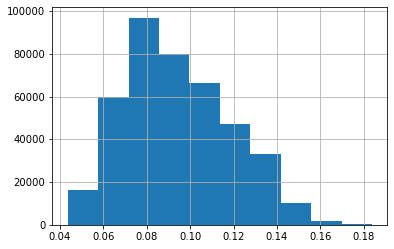

In [89]:
data[['marginal_tax_rate', 'Rf', 'MRP_US', 'ERP', 'ERP_Total',	'beta_unlevered', 'beta_levered_raw', 'beta_levered', 'cost_of_equity']].describe()

data.cost_of_equity.hist()

<AxesSubplot:>

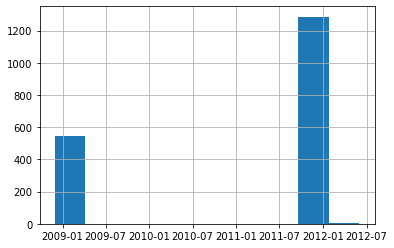

In [92]:
## Check rows with CoE reallt big
data[data.cost_of_equity > 0.16].date.hist()
data[data.cost_of_equity > 0.16]

,index,period,freq,Ticker,date,Asset Turnover,Basic EPS,Basic Shares Outstanding,Book Value Per Share,Cash Flow From Financial Activities,...,Country,marginal_tax_rate,Rf,MRP_US,ERP,ERP_Total,beta_unlevered,beta_levered_raw,beta_levered,cost_of_equity
360842,324410,2020_2,Q,HBCP,2020-06-30,0.0072,0.33,8.7020,34.4999,385.050,...,United States,0.27,0.0066,0.0537,0.0,0.0537,0.098263,0.107674,0.800000,0.049560
360860,326620,2020_2,Q,SMMF,2020-06-30,0.0083,0.54,12.9120,20.3862,139.369,...,United States,0.27,0.0066,0.0537,0.0,0.0537,0.431316,0.564281,0.800000,0.049560
360867,322966,2020_2,Q,BH,2020-06-30,0.0976,121.51,0.3495,229.6414,-4.748,...,United States,0.27,0.0066,0.0537,0.0,0.0537,0.098263,0.130937,0.800000,0.049560
360881,326324,2020_2,Q,RMBI,2020-06-30,0.0077,0.20,12.4810,14.4996,131.157,...,United States,0.27,0.0066,0.0537,0.0,0.0537,0.431316,0.720263,0.800000,0.049560
360884,323215,2020_2,Q,CBFV,2020-06-30,0.0090,0.54,5.3940,28.2521,93.373,...,United States,0.27,0.0066,0.0537,0.0,0.0537,0.431316,0.541548,0.800000,0.049560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404037,352879,2021_3,Q,SCHN,2021-08-31,0.5659,1.53,27.9820,30.5019,-87.286,...,United States,0.27,0.0131,0.0421,0.0,0.0421,0.780000,0.830847,0.830847,0.048079
404038,350458,2021_3,Q,FC,2021-08-31,0.2762,0.13,14.0900,5.6373,-2.720,...,United States,0.27,0.0131,0.0421,0.0,0.0421,0.110000,0.143035,0.800000,0.046780
404039,351237,2021_3,Q,JCTCF,2021-08-31,0.5184,0.18,3.4865,6.5559,2.004,...,United States,0.27,0.0131,0.0421,0.0,0.0421,0.750000,0.821832,0.821832,0.047699
404045,448155,2021,A,SMPL,2021-08-31,0.4900,0.43,95.7430,12.4112,-150.049,...,United States,0.27,0.0131,0.0421,0.0,0.0421,0.530000,0.676945,0.800000,0.046780


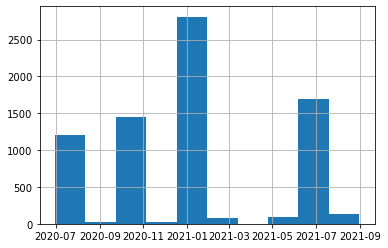

In [94]:
## Check rows with CoE reallt big
data[data.cost_of_equity < 0.05].date.hist()
data[data.cost_of_equity < 0.05]